In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:

from tqdm import tqdm

print(tf.__version__)

# Read in csv files.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

turtle_ids = sorted(np.unique(train.turtle_id)) + ['new_turtle']
turtle_num_lookup = dict(zip(turtle_ids, np.arange(len(turtle_ids))))
turtle_id_lookup = {v: k for k, v in turtle_num_lookup.items()}
train["turtle_num"] = train["turtle_id"].map(turtle_num_lookup)

# Convert image_location strings to lowercase and ensure only allowed strings are present 
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

2.8.0


In [6]:
#Uncomment these to view data info

# train
train.head()
# test.head()
# sample_submission.head()
# train.shape, test.shape, sample_submission.shape
# print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

,Unnamed: 0,image_id,image_location,turtle_id,turtle_num
0,0,ID_2RK4WLN8,top,t_id_VP2NW7aV,57
1,1,ID_VVW0QXLX,left,t_id_qZ0iZYsC,91
2,2,ID_RVATH2HZ,right,t_id_3b65X5Lw,8
3,3,ID_2GB90GPS,left,t_id_YjXYTCGC,61
4,4,ID_LM6S0B1M,top,t_id_d6aYXtor,65


In [12]:
#Count which turtles have biggest turtle_id's
train["turtle_id"].value_counts()

t_id_ROFhVsy2    77
t_id_hRzOoJ2t    68
t_id_VP2NW7aV    58
t_id_Kf73l69A    57
t_id_dVQ4x3wz    47
                 ..
t_id_Lhp87PBX    10
t_id_Dv4O8bOM    10
t_id_p77GDtzg     9
t_id_OqU1NWEA     9
t_id_J5dngbNA     8
Name: turtle_id, Length: 100, dtype: int64

In [4]:
from rembg.bg import remove
import numpy as np
import io
from PIL import Image

if not os.path.isdir('turtle_nobg'):
    os.mkdir('turtle_nobg')

# Uncomment the following lines if working with trucated image formats (ex. JPEG / JPG)
# In my case I do give JPEG images as input, so i'll leave it uncommented
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# input_image = 'turtles-original/ID_00KOI3T9.JPG'
# output_image = 'output-image.png'

for row in train.iterrows():
    image_id = row[1]['image_id']
    src = 'turtles-original/'+ image_id + '.jpg'
    dest = 'turtle_nobg/' + image_id + '.png'
    f = np.fromfile(src)
    result = remove(f)
    img = Image.open(io.BytesIO(result)).convert("RGBA")
    img.save(dest)

In [4]:
#This cell migrates everything from the turtles-original folder into their own respective folders
import shutil

#If "turtle_classes" folder doesn't exist, create it 
if not os.path.isdir('turtle_classes'):
    os.mkdir('turtle_classes')

#For each row in train
for row in train.iterrows():
    turtle_id = row[1]['turtle_id']
    image_id = row[1]['image_id']
    if not os.path.isdir('turtle_classes/' + turtle_id):
        os.mkdir('turtle_classes/' + turtle_id)
    #Get file
    src = 'turtles-original/'+ image_id + '.jpg'
    if os.path.exists(src):
        dst = 'turtle_classes/' + turtle_id + '/' + image_id + '.jpg'
        shutil.copyfile(src, dst)

In [6]:
#This cell does the same but for the no_bg folder
import shutil

#If "turtle_classes" folder doesn't exist, create it 
if not os.path.isdir('turtle_classes_nobg'):
    os.mkdir('turtle_classes_nobg')

#For each row in train
for row in train.iterrows():
    turtle_id = row[1]['turtle_id']
    image_id = row[1]['image_id']
    if not os.path.isdir('turtle_classes_nobg/' + turtle_id):
        os.mkdir('turtle_classes_nobg/' + turtle_id)
    #Get file
    src = 'turtle_nobg/'+ image_id + '.png'
    if os.path.exists(src):
        dst = 'turtle_classes_nobg/' + turtle_id + '/' + image_id + '.png'
        shutil.copyfile(src, dst)

In [22]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  'two_turtles',
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode="grayscale",
#   image_size=(img_height, img_width), #Resize
  batch_size=batch_size)              

val_ds = tf.keras.utils.image_dataset_from_directory(
  'two_turtles',
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode="grayscale",
#   image_size=(img_height, img_width), #Resize
  batch_size=batch_size)

Found 145 files belonging to 2 classes.
Using 116 files for training.
Found 145 files belonging to 2 classes.
Using 29 files for validation.


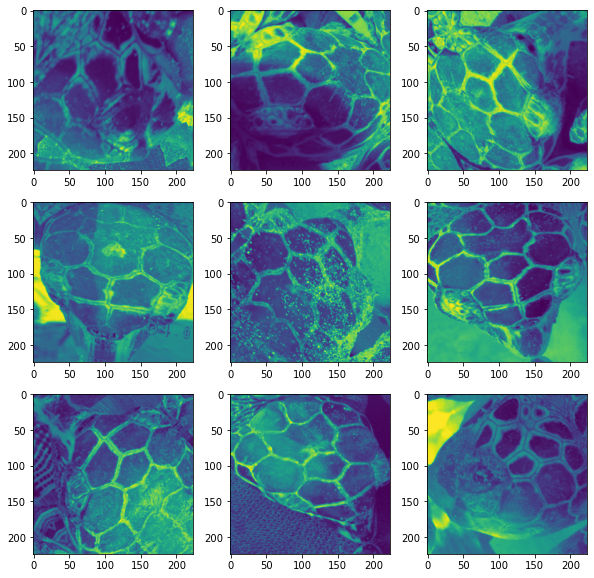

In [23]:
#Data visualization. Comment out layer methods to see different results.
import matplotlib.pyplot as plt
crop_factor = 0.50
IMG_SIZE = 224

image_mod = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomCrop(int(IMG_SIZE*crop_factor),int(IMG_SIZE*crop_factor)),
#   tf.keras.layers.RandomContrast(factor=0.5)
])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    result = image_mod(img)
    _ = plt.imshow(result)


In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32,)


In [25]:
#Standardize RGB values
normalization_layer = tf.keras.layers.Rescaling(1./255)

#Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
num_classes = 2
IMG_SIZE = 224

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomCrop(int(IMG_SIZE*0.95),int(IMG_SIZE*0.95)),
#   tf.keras.layers.RandomContrast(factor=0.2),
#   tf.keras.layers.random_brightness(x, 0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [28]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [29]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
4/4 [==============================] - 3s 596ms/step - loss: 0.8548 - accuracy: 0.5172 - val_loss: 0.7129 - val_accuracy: 0.5517
Epoch 2/5
4/4 [==============================] - 2s 589ms/step - loss: 0.7521 - accuracy: 0.4569 - val_loss: 0.6945 - val_accuracy: 0.4483
Epoch 3/5
4/4 [==============================] - 2s 566ms/step - loss: 0.6983 - accuracy: 0.5345 - val_loss: 0.7116 - val_accuracy: 0.4483
Epoch 4/5
4/4 [==============================] - 2s 560ms/step - loss: 0.6844 - accuracy: 0.5517 - val_loss: 0.7089 - val_accuracy: 0.4483
Epoch 5/5
4/4 [==============================] - 2s 566ms/step - loss: 0.6830 - accuracy: 0.5517 - val_loss: 0.7079 - val_accuracy: 0.4483
